<a href="https://colab.research.google.com/github/prog815/traide/blob/main/%D0%A1%D0%B2%D0%B5%D1%80%D1%82%D0%BA%D0%B8_%D0%B8_%D0%BF%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7_%D0%B7%D0%BD%D0%B0%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключаем библиотеки

In [1]:
! pip install yfinance

     |████████████████████████████████| 6.3 MB 11.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=fe8740332803ebf37ee85535886d60a3566776f93e14e66af7302c92856a45f2
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [41]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Загрузка котировок

## список тикеров

In [3]:
acc_list = "TGKA	FEES	VTBR	TGKB	HYDR	TGKD	TGKN	RSTI	ENRU	SNGS	MRKV	GAZP	MRKZ	MRKP	SNGSP	MAGN	TGKDP	MSNG	MRKC	MRKU	NMTP	NLMK	MTLR	AFLT	MSRS	ROSN	TTLK	FESH	TRMK	RSTIP	RTKM	SIBN	AMEZ	ISKJ	DVEC	RASP	RTKMP	UTAR	LSNG	BSPB	MRKS	MVID	NKNCP	LSNGP	PIKK	KMAZ	IRKT	SVAV	CHEP	MRKK	KUBE	ROSB	KROT".split('\t')
acc_list = [f'{name}.ME' for name in acc_list]
np.array(acc_list)

array(['TGKA.ME', 'FEES.ME', 'VTBR.ME', 'TGKB.ME', 'HYDR.ME', 'TGKD.ME',
       'TGKN.ME', 'RSTI.ME', 'ENRU.ME', 'SNGS.ME', 'MRKV.ME', 'GAZP.ME',
       'MRKZ.ME', 'MRKP.ME', 'SNGSP.ME', 'MAGN.ME', 'TGKDP.ME', 'MSNG.ME',
       'MRKC.ME', 'MRKU.ME', 'NMTP.ME', 'NLMK.ME', 'MTLR.ME', 'AFLT.ME',
       'MSRS.ME', 'ROSN.ME', 'TTLK.ME', 'FESH.ME', 'TRMK.ME', 'RSTIP.ME',
       'RTKM.ME', 'SIBN.ME', 'AMEZ.ME', 'ISKJ.ME', 'DVEC.ME', 'RASP.ME',
       'RTKMP.ME', 'UTAR.ME', 'LSNG.ME', 'BSPB.ME', 'MRKS.ME', 'MVID.ME',
       'NKNCP.ME', 'LSNGP.ME', 'PIKK.ME', 'KMAZ.ME', 'IRKT.ME', 'SVAV.ME',
       'CHEP.ME', 'MRKK.ME', 'KUBE.ME', 'ROSB.ME', 'KROT.ME'], dtype='<U8')

## Загрузка из сети

In [4]:
all_data = yf.download(acc_list,period='10y',threads=False)


[*********************100%***********************]  53 of 53 completed


In [5]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2507 entries, 2011-08-19 to 2021-08-19
Columns: 318 entries, ('Adj Close', 'AFLT.ME') to ('Volume', 'VTBR.ME')
dtypes: float64(318)
memory usage: 6.1 MB


## Заполнить пустоты предыдущим

In [6]:
all_data.fillna(method='pad',inplace=True)

# Подготовка данных

## К общему знаменателю (без сдвига)

### Входы (курсы + объем) (без сдвига)

In [7]:
# inpData1 = np.hstack([(all_data[gr] / all_data['Close'].shift(1)).values for gr in ('Open','High','Low','Close')])
# inpData1.shape
d = [all_data[gr]/all_data['Close'].shift(1) for gr in ('Open','High','Low','Close')]
v = all_data['Volume'].apply(np.log1p)
v = v.diff()
d.append(v)
d = np.hstack([x.values for x in d])
d.shape

(2507, 265)

### Выход

In [13]:
# outDataHigh = (all_data['High'] / all_data['Close'].shift(1)).values
# outDataLow = (all_data['Low'] / all_data['Close'].shift(1)).values
output = np.array((all_data['Close'].diff() > 0) * 1)
output.shape

(2507, 53)

## Первый вход в окно (без сдвига)

In [14]:
WINDOW = 10
# d = pd.DataFrame(inpData1)
# inpData1 = np.hstack([d.shift(n).values for n in range(WINDOW)])
# inpData1.shape
inpData1 = np.ones((d.shape[0],WINDOW,d.shape[-1]))
d = pd.DataFrame(d)
for n in range(WINDOW):
    inpData1[:,n,:] = d.shift(n).values
inpData1.shape

(2507, 10, 265)

## Второй вход - даты (без сдвига)

In [15]:
days = all_data.index.day.values
weekdays = all_data.index.weekday.values
months = all_data.index.month.values
x2sc = lambda x,per: np.transpose([np.sin(x/per),np.cos(x/per)])
inpData2 = np.hstack([x2sc(days,31),x2sc(weekdays,7),x2sc(months,12)])
inpData2.shape

(2507, 6)

## Разделяем обучение и расчет (появляется сдвиг)

In [16]:
inpData1Calc = inpData1[-1,...]

inpData1Learn = inpData1
inpData1Learn[1:,...] = inpData1Learn[:-1,...]

inpData2Calc = inpData2[-1,...]

inpData2Learn = inpData2
inpData2Learn[1:,...] = inpData2Learn[:-1,...]

In [17]:
inpData1Learn.shape,inpData2Learn.shape

((2507, 10, 265), (2507, 6))

In [18]:
inpData1Calc.shape,inpData2Calc.shape

((10, 265), (6,))

In [19]:
output.shape

(2507, 53)

## Чистим пустоты на обучении

In [20]:
index = (~np.isnan(np.sum(inpData1Learn,axis=(1,2)))) & (~np.isnan(np.sum(inpData2Learn,axis=1))) & (~np.isnan(np.sum(output,axis=1)))
np.unique(index,return_counts=True)

(array([False,  True]), array([  11, 2496]))

In [21]:
inpData1Learn = inpData1Learn[index,:]
inpData2Learn = inpData2Learn[index,:]
output = output[index,:]
learnDates = all_data.index.values[index]

In [22]:
print('inpData1Learn size',inpData1Learn.shape)
print('inpData2Learn size',inpData2Learn.shape)
print('output size',output.shape)
print('Learn dates from',learnDates[0],'to',learnDates[-1])

inpData1Learn size (2496, 10, 265)
inpData2Learn size (2496, 6)
output size (2496, 53)
Learn dates from 2011-09-05T00:00:00.000000000 to 2021-08-19T00:00:00.000000000


## Разделение на обучение и тест

In [23]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test, d_train, d_test = train_test_split(inpData1Learn,inpData2Learn,output,learnDates,test_size=0.33,shuffle=False)

## Нормировка данных (слой нормировки первого входа)

In [24]:
normLayer = keras.layers.experimental.preprocessing.Normalization(axis=-1)
normLayer.adapt(X1_train)

# Модель

## Слои

In [48]:
input1 = keras.layers.Input(shape=X1_train.shape[1:])
x1 = normLayer(input1)

x1 = keras.layers.Conv1D(50,2,padding='same',activation='relu')(x1)

x1 = keras.layers.Flatten()(x1)

input2 = keras.layers.Input(shape=(X2_train.shape[1],))

x = keras.layers.Concatenate()([x1,input2])

output = keras.layers.Dense(1)(x)

model = keras.Model((input1,input2),output)
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 10, 265)]    0                                            
__________________________________________________________________________________________________
normalization (Normalization)   (None, 10, 265)      531         input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 10, 50)       26550       normalization[2][0]              
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 500)          0           conv1d_2[0][0]                   
____________________________________________________________________________________________

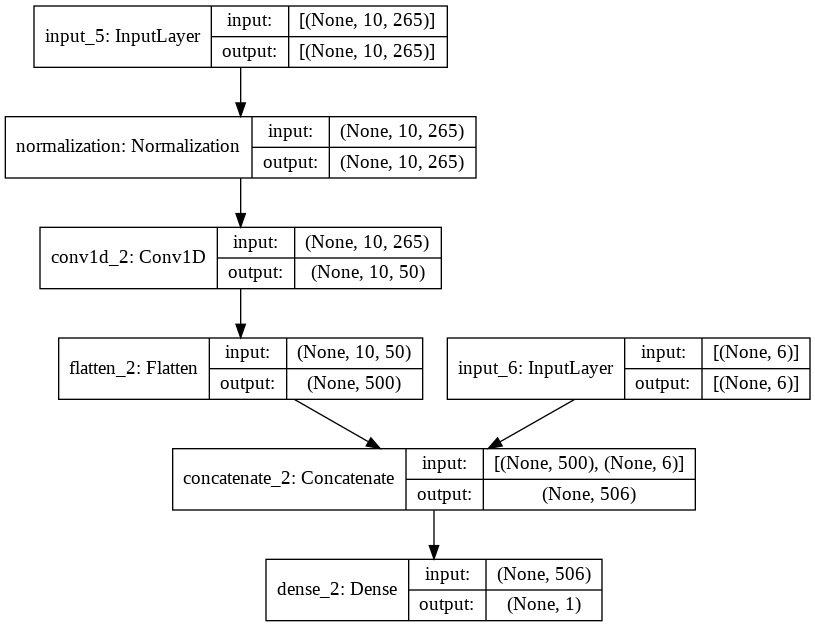

In [49]:
keras.utils.plot_model(model,show_shapes=True)

## Обучение

In [50]:
cb = [tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',mode='max',patience=100,restore_best_weights=True,verbose=True),
      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy',mode='max',patience=50,verbose=True)]
history = model.fit((X1_train,X2_train),y_train[:,0],
                    epochs=1000,
                    validation_split=0.3,
                    callbacks = cb)

Epoch 1/1000
37/37 [==============================] - 1s 8ms/step - loss: 5.5178 - binary_accuracy: 0.5111 - val_loss: 5.2870 - val_binary_accuracy: 0.4641
Epoch 2/1000
37/37 [==============================] - 0s 4ms/step - loss: 5.2143 - binary_accuracy: 0.5590 - val_loss: 5.5369 - val_binary_accuracy: 0.4801
Epoch 3/1000
37/37 [==============================] - 0s 5ms/step - loss: 5.1946 - binary_accuracy: 0.5846 - val_loss: 6.4031 - val_binary_accuracy: 0.4900
Epoch 4/1000
37/37 [==============================] - 0s 5ms/step - loss: 4.8992 - binary_accuracy: 0.5795 - val_loss: 5.6378 - val_binary_accuracy: 0.4542
Epoch 5/1000
37/37 [==============================] - 0s 5ms/step - loss: 5.1891 - binary_accuracy: 0.5761 - val_loss: 5.8741 - val_binary_accuracy: 0.4602
Epoch 6/1000
37/37 [==============================] - 0s 4ms/step - loss: 5.0611 - binary_accuracy: 0.5786 - val_loss: 5.7473 - val_binary_accuracy: 0.5060
Epoch 7/1000
37/37 [==============================] - 0s 5ms/ste

## Отчет обучения

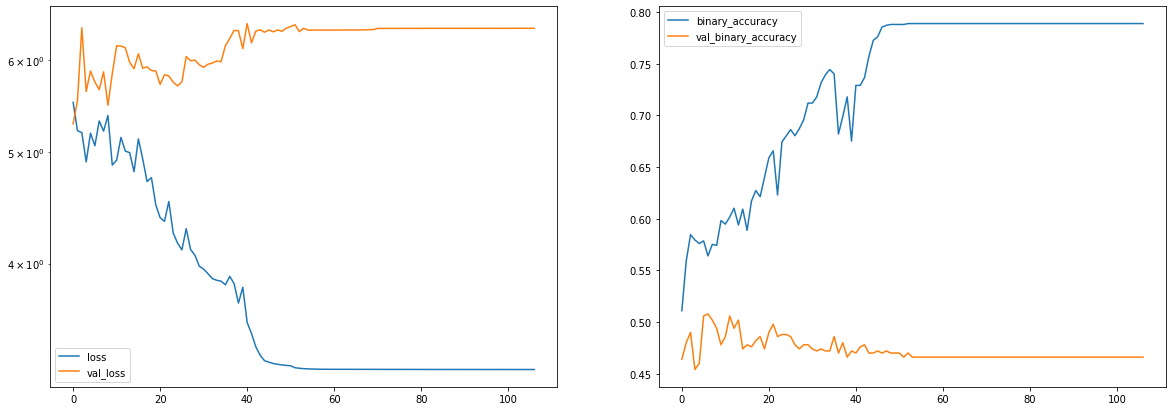

In [51]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.yscale('log')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['binary_accuracy'],label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'],label='val_binary_accuracy')
# plt.yscale('log')
plt.legend()


plt.show()

## Отчет на тесте

In [52]:
model.evaluate([X1_test,X2_test],y_test[:,0])

26/26 [==============================] - 0s 2ms/step - loss: 5.4792 - binary_accuracy: 0.5231


[5.479236125946045, 0.5230582356452942]

In [53]:
test_res = model([X1_test,X2_test]).numpy()

print(classification_report(y_test[:,0],np.reshape((test_res > 0) * 1,-1)))



              precision    recall  f1-score   support

           0       0.53      0.57      0.55       445
           1       0.45      0.41      0.43       379

    accuracy                           0.50       824
   macro avg       0.49      0.49      0.49       824
weighted avg       0.50      0.50      0.50       824

